In [1]:
import os
import glob
import time
import shutil
import gc

import numpy as np
import matplotlib.pyplot as plt

import hapod as hp


In [2]:
memory_avail_total = hp.get_memory_size()
memory_forbidden = 2**30
print(f"total available memory is {memory_avail_total / 2**30:.2f} GB")
print(f"but {memory_forbidden / 2**30:.2f} GB will be made unavailable")

serializer = hp.NumpySerializer()

dtype = np.float64
n_rows = 3600000
refresh_snapshots = False
refresh_chunks = refresh_snapshots or False
refresh_hapod = refresh_chunks or True
refresh_rand = refresh_chunks or True
refresh_piecewise = refresh_chunks or True

n_svd_max_cols = hp.get_max_svd_columns(n_rows, 
                                        memory_limit=memory_avail_total - memory_forbidden,
                                        dtype=dtype)
print(f"the largest matrix for SVD is {n_rows, n_svd_max_cols} using {dtype}")

n_chunk_max_cols = n_svd_max_cols // 2
print(f"the hapod can use chunks of {n_chunk_max_cols} columns")


total available memory is 15.56 GB
but 1.00 GB will be made unavailable
the largest matrix for SVD is (3600000, 124) using <class 'numpy.float64'>
the hapod can use chunks of 62 columns


In [3]:
n_cols = n_chunk_max_cols * 16
snapshots_matrix_memory = hp.get_matrix_memory_footprint((n_rows, n_cols), dtype=dtype)
print(f"a snapshots matrix of size {n_rows, n_cols} would use {snapshots_matrix_memory / 2**30:.2f} GB of memory")
print(f"    SVD would use {hp.get_svd_memory_footprint((n_rows, n_cols), dtype=dtype) / 2**30:.2f} GB of memory")

n_chunks = hp.get_n_chunks_fulltree(n_cols, n_chunk_max_cols=n_chunk_max_cols)
print(f"for a balanced, full, merge tree, will need {n_chunks} chunks with maximum size {n_chunk_max_cols} >= {n_cols / n_chunks:.3f} average")


a snapshots matrix of size (3600000, 992) would use 26.61 GB of memory
    SVD would use 116.01 GB of memory
for a balanced, full, merge tree, will need 16 chunks with maximum size 62 >= 62.000 average


In [4]:
n_randomized_svd_max_cols = hp.get_max_randomized_svd_samples((n_rows, n_cols),
                                  memory_limit=memory_avail_total - memory_forbidden,
                                  )
print(f"randomized SVD can use {n_randomized_svd_max_cols} samples")
print(f"which correspond to {hp.get_randomized_svd_memory_footprint((n_rows, n_cols), n_randomized_svd_max_cols, dtype=dtype) / 2**30:.2f} GB of memory")


randomized SVD can use 83 samples
which correspond to 14.47 GB of memory


In [5]:
from tests.test_base import get_test_matrix_full_rank

X_fullrank, U_fullrank, s_true = get_test_matrix_full_rank(n_rows= n_cols,
                                                            n_cols = n_cols,
                                                            dtype = dtype,
                                                            return_Us = True)


In [6]:
work_dir = "/scratch/lfabris/hapod_test"
os.makedirs(work_dir, exist_ok=True)


np.save(os.path.join(work_dir, "X_fullrank"), X_fullrank)
np.save(os.path.join(work_dir, "U_fullrank"), U_fullrank)
np.save(os.path.join(work_dir, "s_true"), s_true)

In [7]:
snapshots_dir = os.path.join(work_dir, "snapshots")
print(f"simulating a snapshot matrix with size {(n_rows, n_cols)} under {snapshots_dir}")

if not os.path.isdir(snapshots_dir) or refresh_snapshots:
    print(f"create snapshots under {snapshots_dir}")
    shutil.rmtree(snapshots_dir, ignore_errors=True)
    os.makedirs(snapshots_dir, exist_ok=True)

    print(
        f"storing {snapshots_matrix_memory / 2**30:.3f} GB worth of snapshots"
    )

    rng = np.random.default_rng()

    elapsed_snapshots = -time.perf_counter()
    snapshots_fnames = []
    for i in range(n_cols):
        x = np.concatenate([X_fullrank[:, i], 
                                np.zeros(n_rows-n_cols, dtype=dtype)], 
                            axis=0).reshape(-1, 1)
        snapshot_fname = os.path.join(snapshots_dir, f"snapshot_{i:04d}")
        snapshot_fname = serializer.store(x, snapshot_fname)

        snapshots_fnames.append(snapshot_fname)
    elapsed_snapshots += time.perf_counter()
    print(f"created {len(snapshots_fnames)} snapshot files in {elapsed_snapshots:.3f}")
else:
    snapshots_fnames = list(glob.glob(os.path.join(snapshots_dir, "*.npy")))
    print(f"found {len(snapshots_fnames)} snapshot files in {snapshots_dir}")
    

simulating a snapshot matrix with size (3600000, 992) under /scratch/lfabris/hapod_test/snapshots
found 992 snapshot files in /scratch/lfabris/hapod_test/snapshots


In [8]:
chunks_dir = os.path.join(work_dir, "chunks")
print(f"simulating chunks of maximum size {n_rows, n_chunk_max_cols} under {chunks_dir}")

if not os.path.isdir(chunks_dir) or refresh_chunks:
    print(f"create chunks under {chunks_dir}")
    shutil.rmtree(chunks_dir, ignore_errors=True)
    os.makedirs(chunks_dir, exist_ok=True)

    elapsed_chunks = -time.perf_counter()
    chunks_fnames = hp.make_chunks(
        snapshots_fnames,
        chunks_dir,
        n_chunks=n_chunks,
        serializer=serializer,
    )
    elapsed_chunks += time.perf_counter()
    print(f"created {len(chunks_fnames)} column chunks files in {elapsed_chunks:.3f}")
else:
    chunks_fnames = list(glob.glob(os.path.join(chunks_dir, "*.npy")))
    print(f"found {len(chunks_fnames)} column chunks files in {chunks_dir}")


simulating chunks of maximum size (3600000, 62) under /scratch/lfabris/hapod_test/chunks
found 16 column chunks files in /scratch/lfabris/hapod_test/chunks


In [9]:
gc.collect()

0

In [10]:
if refresh_hapod:
    hapod_tmp_dir = os.path.join(work_dir, "tmp")

    elapsed_hapod = -time.perf_counter()
    U_hapod, s_hapod = hp.hapod(chunks_fnames,
                    chunk_rank_max=n_chunk_max_cols,
                    temp_work_dir=hapod_tmp_dir,
                    serializer=serializer,
                    verbose=True)
    elapsed_hapod += time.perf_counter()

    print(f"finished hapod in {elapsed_hapod:.3f}")
    print(f"    U.shape {U_hapod.shape}")
    print(f"    s_hapod.shape {s_hapod.shape}")

    np.save(os.path.join(work_dir, "U_hapod.npy"), U_hapod)
    np.save(os.path.join(work_dir, "s_hapod.npy"), s_hapod)

    U_hapod = None
    del U_hapod
else:
    s_hapod = np.load(os.path.join(work_dir, "s_hapod.npy"))


Xs
    /scratch/lfabris/hapod_test/chunks/chunk_0006.npy ((3600000, 62), dtype('float64'))
    /scratch/lfabris/hapod_test/chunks/chunk_0009.npy ((3600000, 62), dtype('float64'))
    /scratch/lfabris/hapod_test/chunks/chunk_0011.npy ((3600000, 62), dtype('float64'))
    /scratch/lfabris/hapod_test/chunks/chunk_0007.npy ((3600000, 62), dtype('float64'))
    /scratch/lfabris/hapod_test/chunks/chunk_0002.npy ((3600000, 62), dtype('float64'))
    /scratch/lfabris/hapod_test/chunks/chunk_0013.npy ((3600000, 62), dtype('float64'))
    /scratch/lfabris/hapod_test/chunks/chunk_0014.npy ((3600000, 62), dtype('float64'))
    /scratch/lfabris/hapod_test/chunks/chunk_0010.npy ((3600000, 62), dtype('float64'))
    /scratch/lfabris/hapod_test/chunks/chunk_0005.npy ((3600000, 62), dtype('float64'))
    /scratch/lfabris/hapod_test/chunks/chunk_0000.npy ((3600000, 62), dtype('float64'))
    /scratch/lfabris/hapod_test/chunks/chunk_0003.npy ((3600000, 62), dtype('float64'))
    /scratch/lfabris/hapod_te

In [11]:
gc.collect()

847

In [12]:
if refresh_rand:
    elapsed_rand = -time.perf_counter()
    U_rand, s_rand = hp.randomized_pod(snapshots_fnames,
                                       n_sources_samples=n_randomized_svd_max_cols,
                                       serializer=serializer,)
    elapsed_rand += time.perf_counter()

    print(f"finished rand in {elapsed_rand:.3f}")
    print(f"    U_rand.shape {U_rand.shape}")
    print(f"    s_rand.shape {s_rand.shape}")

    np.save(os.path.join(work_dir, "U_rand.npy"), U_rand)
    np.save(os.path.join(work_dir, "s_rand.npy"), s_rand)

    U_rand = None
    del U_rand
else:
    s_rand = np.load(os.path.join(work_dir, "s_rand.npy"))


finished rand in 908.746
    U_rand.shape (3600000, 83)
    s_rand.shape (83,)


In [ ]:
gc.collect()

In [ ]:
if refresh_piecewise:
    n_cols_piecewise = 2 * n_chunk_max_cols
    elapsed_piecewise = -time.perf_counter()
    s_piecewise, V_piecewise = hp.piecewise_sV(chunks_fnames, serializer, eigenvtol=1e-16)
    s_piecewise = s_piecewise[:n_cols_piecewise]
    V_piecewise = V_piecewise[:, :n_cols_piecewise]

    U_piecewise = hp.piecewise_U(chunks_fnames,
                               s_piecewise, 
                               V_piecewise, 
                               serializer)
    elapsed_piecewise += time.perf_counter()

    print(f"finished piecewise in {elapsed_piecewise:.3f}")
    print(f"    U_piecewise.shape {U_piecewise.shape}")
    print(f"    s_piecewise.shape {s_piecewise.shape}")
    
    np.save(os.path.join(work_dir, "U_piecewise.npy"), U_piecewise)
    np.save(os.path.join(work_dir, "s_piecewise.npy"), s_piecewise)

    U_piecewise = None
    del U_piecewise
else:
    U_piecewise = np.load(os.path.join(work_dir, "U_piecewise.npy"))
    s_piecewise = np.load(os.path.join(work_dir, "s_piecewise.npy"))

finished piecewise in 1849.663
    U_piecewise.shape (3600000, 124)
    s_piecewise.shape (124,)


In [15]:
gc.collect()

246

In [ ]:
#to compare with the fullrank svecs, the "full length" Us need to be truncated
#the fullrank matrix was (n_cols, n_cols), so only the first n_cols elems are used
#and the rest of the Us are garbage

fname = os.path.join(work_dir, "U_hapod.npy")
(_, n_cols_hapod), _ = serializer.peek(fname)
ortho_hapod = hp.get_singular_vectors_orthogonality(np.load(fname)[:n_cols], 
                                                U_fullrank[:, :n_cols_hapod])

fname = os.path.join(work_dir, "U_rand.npy")
(_, n_cols_rand), _ = serializer.peek(fname)
ortho_rand = hp.get_singular_vectors_orthogonality(np.load(fname)[:n_cols], 
                                                U_fullrank[:, :n_cols_rand])

fname = os.path.join(work_dir, "U_piecewise.npy")
(_, n_cols_piecewise), _ = serializer.peek(fname)
ortho_piecewise = hp.get_singular_vectors_orthogonality(np.load(fname)[:n_cols], 
                                                U_fullrank[:, :n_cols_piecewise])


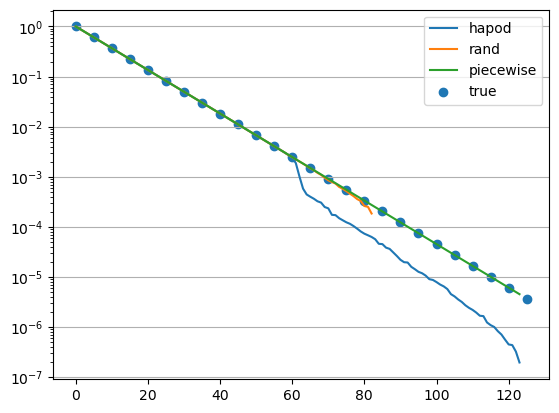

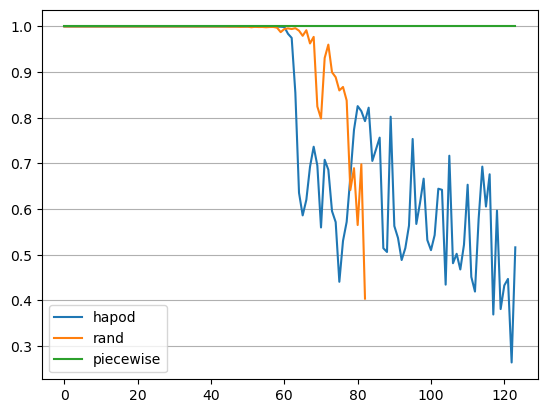

In [18]:
n_ranks = 5 + max(n_randomized_svd_max_cols, n_chunk_max_cols, n_cols_piecewise)

plt.semilogy(s_hapod[:n_ranks], label="hapod")
plt.semilogy(s_rand[:n_ranks], label="rand")
plt.semilogy(s_piecewise[:n_ranks], label="piecewise")
plt.scatter(np.arange(n_ranks)[::5], s_true[:n_ranks][::5], label="true")

plt.legend()
plt.grid(axis="y")

plt.show()
plt.close()

plt.plot(ortho_hapod, label="hapod")
plt.plot(ortho_rand, label="rand")
plt.plot(ortho_piecewise, label="piecewise")

plt.legend()
plt.grid(axis="y")

plt.show()
plt.close()
